In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [6]:
data_path = fr'{os.getenv("HOME")}/downloads/AnimalFace'
os.listdir(data_path)

['MonkeyHead',
 '.DS_Store',
 'Natural',
 'BearHead',
 'PigHead',
 'CatHead',
 'MouseHead',
 'WolfHead',
 'HumanHead',
 'PigeonHead',
 'CowHead',
 'SheepHead',
 'ChickenHead',
 'TigerHead',
 'EagleHead',
 'PandaHead',
 'RabbitHead',
 'DogHead',
 'DuckHead',
 'LionHead',
 'ElephantHead',
 'DeerHead']

In [7]:
base_name = 'animal_faces'
width = 80
 
include = {'DogHead', 'BearHead', 'SheepHead', 
           'EagleHead', 'DuckHead', 'TigerHead', 'PandaHead',
           'HumanHead', 'RabbitHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)


BearHead
HumanHead
SheepHead
TigerHead
EagleHead
PandaHead
RabbitHead
DogHead
DuckHead


In [8]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1218
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Dog' 'Duck' 'Eagle' 'Human' 'Panda' 'Rabbit' 'Sheep' 'Tiger']


Counter({'Dog': 389,
         'Panda': 117,
         'Tiger': 112,
         'Duck': 102,
         'Bear': 101,
         'Human': 100,
         'Sheep': 100,
         'Rabbit': 100,
         'Eagle': 97})

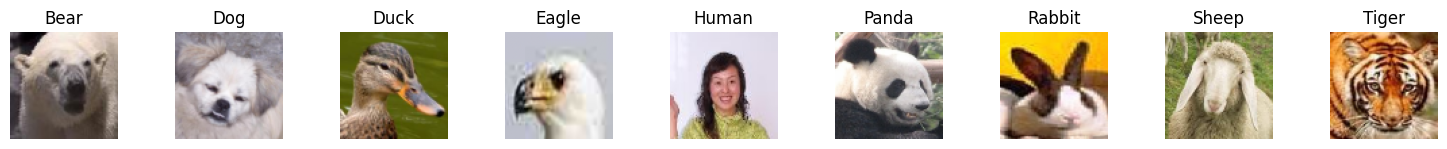

In [10]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [12]:
x = data['data']
y = np.array(data['label'])

In [13]:
from sklearn.model_selection import train_test_split
 
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

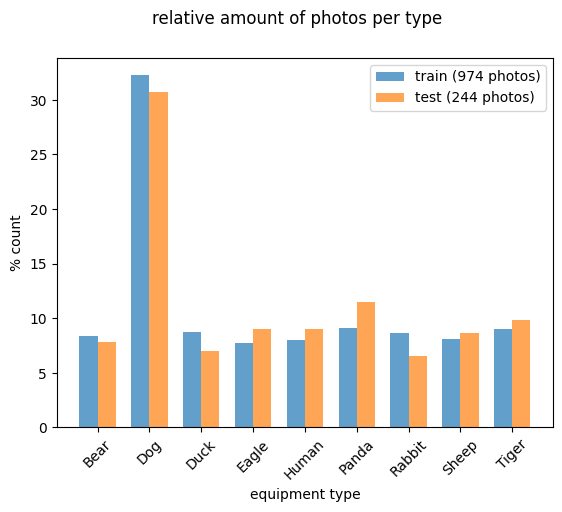

In [14]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage.feature import hog

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([rgb2gray(img) if img.ndim == 3 else img_as_ubyte(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
x_train_gray = grayify.fit_transform(x_train)
x_train_hog = hogify.fit_transform(x_train_gray)
x_train_prepared = scalify.fit_transform(x_train_hog)
 
print(x_train_prepared.shape)

(974, 576)


In [24]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(x_train_prepared, y_train)

SGDClassifier(random_state=42)

In [25]:
x_test_gray = grayify.transform(x_test)
x_test_hog = hogify.transform(x_test_gray)
x_test_prepared = scalify.transform(x_test_hog)

In [26]:
y_pred = sgd_clf.predict(x_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))


[False  True  True  True  True False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True]

Percentage correct:  77.8688524590164


In [29]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[11,  7,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 68,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  2, 11,  2,  0,  0,  1,  1,  0],
       [ 0,  4,  0, 17,  0,  0,  0,  1,  0],
       [ 0,  3,  0,  0, 18,  0,  1,  0,  0],
       [ 0,  8,  0,  0,  0, 19,  0,  0,  1],
       [ 1,  4,  0,  0,  0,  0, 10,  1,  0],
       [ 1,  2,  0,  0,  0,  0,  1, 17,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  0, 19]])


 ['Bear', 'Dog', 'Duck', 'Eagle', 'Human', 'Panda', 'Rabbit', 'Sheep', 'Tiger']


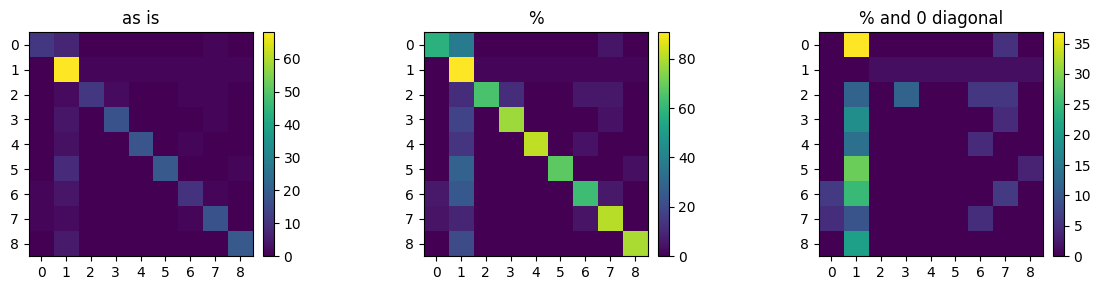

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
print('\n', sorted(np.unique(y_test)))

In [52]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(x_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(x_test) == y_test)/len(y_test))


Percentage correct:  77.8688524590164


In [55]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [56]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [57]:
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [58]:
# description of the best performing object
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(kernel='linear'))])

In [61]:
# the highscore during the search
grid_res.best_score_

0.8675593542260209

In [62]:
pp.pprint(grid_res.best_params_)

{   'classify': SVC(kernel='linear'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


In [64]:
best_pred = grid_res.predict(x_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  89.75409836065573


In [68]:
cmx_svm = confusion_matrix(y_test, best_pred)

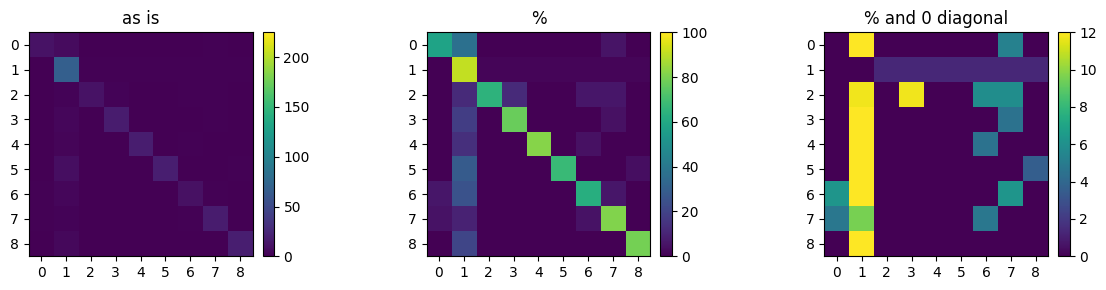

In [70]:
# before results
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

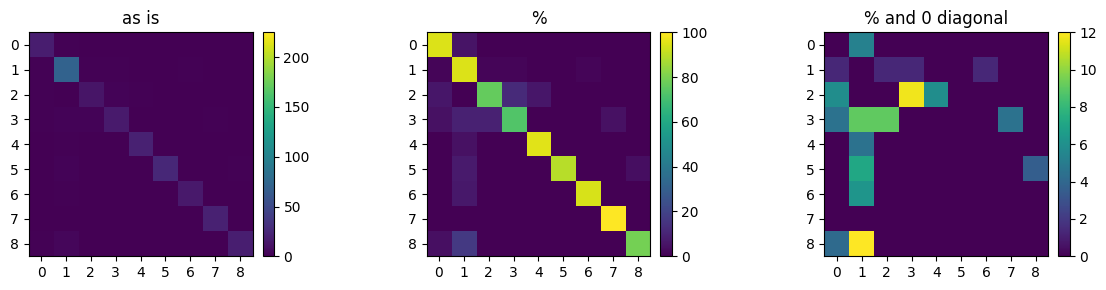

In [71]:
# after gridsearchCV results
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)